In [1]:
import axs
import numpy as np

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

import pandas as pd
import matplotlib.pyplot as plt

import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as pyspark_types
import numpy as np

from functools import partial

import tqdm

import dipper

In [2]:
%matplotlib notebook

# Setup spark

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[6]")
            #.config("spark.master", "local[32]") # yolo mode
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/jrad/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

Hovering over "Spark UI" above gives you the port number of the Spark web dashboard.  Epyc doesn't have that port open, though, so we use an SSH tunnel to forward the ports.  I like to put the following function into my `.bashrc` o my local machine:


```
function spark_tunnel()
{
        # this function takes one argument: the epyc port to tunnel
        # the ordering is backwards (requiring a manual refresh) because
        # I want to be able to manually kill the ssh tunnel
        open http://localhost:${1}/
        ssh -N -L ${1}:127.0.0.1:${1} username@epyc.astro.washington.edu
}
```

# Detect dippers

In [5]:
# def get_separated_times_mask(mjd, min_dt=0.5):
#     """Get a mask that only selects observations that are separated by a minimum
#     amount of time
#     """
#     min_time_mask = (mjd - np.roll(mjd, 1)) > min_dt
#     if len(min_time_mask) > 0:
#         min_time_mask[0] = True
#     return min_time_mask


# def parse_observations(mjd, mag, magerr, xpos, ypos, catflags):
#     """Parse a list of observations and convert them to a set of
#     differences in magnitudes with uncertainties.
    
#     Bad observations will be removed.
    
#     Returns
#     -------
#     parsed_mjd : numpy.array
#         Sorted array of parsed MJDs.
#     parsed_mag : numpy.array
#         Corresponding magnitude differences relative to the median flux
#     parsed_magerr : numpy.array
#         Magnitude uncertainties, including contributions from the intrinsic dispersion
#         if applicable.
#     """
#     if len(mjd) == 0:
#         return [], [], []

#     mjd = np.array(mjd)
#     order = np.argsort(mjd)

#     # Convert everything to numpy arrays and sort them by MJD
#     sort_mjd = mjd[order]
#     sort_mag = np.array(mag)[order]
#     sort_magerr = np.array(magerr)[order]
#     sort_xpos = np.array(xpos)[order]
#     sort_ypos = np.array(ypos)[order]
#     sort_catflags = np.array(catflags)[order]

#     # Mask out bad or repeated observations.
#     pad_width = 20
#     x_border = 3072
#     y_border = 3080

#     mask = (
#         (np.abs(sort_mjd - np.roll(sort_mjd, 1)) > 1e-5)
#         & (sort_xpos > pad_width)
#         & (sort_xpos < x_border - pad_width)
#         & (sort_ypos > pad_width)
#         & (sort_ypos < y_border - pad_width)
#         & (sort_catflags == 0)
        
#         # In the oct19 data, some observations have a magerr of 0 and aren't flagged.
#         # This causes a world of problems, so throw them out.
#         & (sort_magerr > 0)
        
#         # In the oct19 data, a lot of dippers are the result of bad columns...
#         # Unfortunately, in this version of the ZTF data we don't know which amplifier
#         # everything came from. To get a reasonably clean sample (with some unnecessary
#         # attrition), we cut any observations that are in the "bad" x ranges.
#         & ((sort_xpos < 24) | (sort_xpos > 31))
#         & ((sort_xpos < 95) | (sort_xpos > 106))
#         & ((sort_xpos < 328) | (sort_xpos > 333))
#         & ((sort_xpos < 1169) | (sort_xpos > 1177))
#         & ((sort_xpos < 1249) | (sort_xpos > 1257))
#         & ((sort_xpos < 1339) | (sort_xpos > 1349))
#         & ((sort_xpos < 2076) | (sort_xpos > 2100))
#         & ((sort_xpos < 2521) | (sort_xpos > 2537))
#         & ((sort_xpos < 2676) | (sort_xpos > 2682))
#         & ((sort_xpos < 2888) | (sort_xpos > 2895))
#     )

#     if np.sum(mask) < 10:
#         # Require at least 10 observations to have reasonable statistics.
#         return [], [], []
        
#     mask_mjd = sort_mjd[mask]
#     mask_mag = sort_mag[mask]
#     mask_magerr = sort_magerr[mask]

#     # Calculate statistics on the light curve. To avoid being affected by periods with
#     # many rapid observations, we only consider observations that are separated by
#     # a given amount of time.
#     min_time_mask = get_separated_times_mask(mask_mjd)
    
#     use_mag = mask_mag[min_time_mask]
        
#     # Subtract the reference flux from the observations.
#     base_mag = np.median(use_mag)
#     parsed_mag = mask_mag - base_mag
    
#     return mask_mjd, parsed_mag, mask_magerr

# def detect_dippers(mjd_g, mag_g, magerr_g, xpos_g, ypos_g, catflags_g,
#                    mjd_r, mag_r, magerr_r, xpos_r, ypos_r, catflags_r,
#                    max_dt=2., min_nobs=3, min_dip_time=2., threshold=3.):
    
#     parsed_mjd_g, parsed_mag_g, parsed_magerr_g = parse_observations(
#         mjd_g, mag_g, magerr_g, xpos_g, ypos_g, catflags_g
#     )
#     parsed_mjd_r, parsed_mag_r, parsed_magerr_r = parse_observations(
#         mjd_r, mag_r, magerr_r, xpos_r, ypos_r, catflags_r
#     )
    
#     mjd = np.hstack([parsed_mjd_g, parsed_mjd_r])
#     order = np.argsort(mjd)
#     mjd = mjd[order]
#     mag = np.hstack([parsed_mag_g, parsed_mag_r])[order]
#     magerr = np.hstack([parsed_magerr_g, parsed_magerr_r])[order]
    
#     significance = mag / magerr
    
#     # Measure dips. The dip is defined as all observations with decrease
#     # in flux with a significance greater than the given threshold. We require
#     # that observations of the dip have a cadence of at most max_dt, and that
#     # there are observations with no significance on either side of the dip.
#     # Note that the filters have been merged together (after subtracting the
#     # reference flux), so we are looking for relatively gray dips.    
    
#     dip_start_mjd = None
    
#     best_intmag = -1.
#     best_start_mjd = float('nan')
#     best_end_mjd = float('nan')
#     best_nobs = 0
#     best_complexity = float('nan')

#     num_dips = 0

#     for idx in range(1, len(mjd)):        
#         if mjd[idx] - mjd[idx-1] > max_dt:
#             # We have a gap in observations larger than our desired threshold.
#             # The previous dip (if there was one) can't be used.
            
#             # Reset
#             dip_start_mjd = None
#         elif significance[idx] >= threshold:
#             # Found a significant observation. Increase the current nobs.

#             if dip_start_mjd is None:
#                 if significance[idx-1] >= threshold:
#                     # Continuation of a dip that we didn't identify the start of.
#                     # Ignore it.
#                     pass
#                 else:
#                     # Found the start of a dip. Start recording it.
#                     dip_start_mjd = mjd[idx]

#                     dip_intmag = 0.
#                     dip_nobs = 1
#                     dip_max_mag = mag[idx]
#                     dip_sum_deltas = mag[idx] - magerr[idx]
#             else:
#                 # Inside of a dip.
#                 dip_nobs += 1
                
#                 # Integrate the magnitude using the trapezoid rule.
#                 mean_mag = (mag[idx] + mag[idx-1]) / 2.
#                 dt = mjd[idx] - mjd[idx-1]
#                 dip_intmag += dt * mean_mag
                
#                 if mag[idx] > dip_max_mag:
#                     dip_max_mag = mag[idx]
                
#                 dip_sum_deltas += np.abs(mag[idx] - mag[idx-1]) - magerr[idx]
#         elif dip_start_mjd is not None:
#             # We found the end of a dip. Record it if it is the best one.
#             dip_sum_deltas += mag[idx-1] - magerr[idx]
            
#             dip_complexity = dip_sum_deltas / dip_max_mag / 2.
            
#             if (dip_intmag > best_intmag
#                     and dip_nobs >= min_nobs
#                     and (mjd[idx-1] - dip_start_mjd) > min_dip_time):
#                 best_intmag = dip_intmag
#                 best_start_mjd = dip_start_mjd
#                 best_end_mjd = mjd[idx-1]
#                 best_nobs = dip_nobs
#                 best_complexity = dip_complexity

#             # Reset
#             dip_start_mjd = None
    
#         # Count the total number of dips. We don't care if we capture the edges properly
#         # for this, we just care about finding every time that we transition above the
#         # threshold. This is helpful for vetoing highly variable objects.
#         if significance[idx] > threshold and significance[idx - 1] < threshold:
#             num_dips += 1
            
#     # Get a measure of the significance of the dip by comparing the integrated size
#     # of the dip to the typical variation scale of the light curve. We calculate the typical
#     # variance using observations outside of the 
#     mask = (
#         ((mjd < best_start_mjd - 5) | (mjd > best_end_mjd + 5))
#         & get_separated_times_mask(mjd)
#     )

#     if np.sum(mask) < 5:
#         dip_significance = 0.
#     else:
#         mask_std = np.std(mag[mask])
#         dip_significance = best_intmag / mask_std
                        
#     return (
#         float(best_intmag),
#         float(best_start_mjd),
#         float(best_end_mjd),
#         int(best_nobs),
#         float(best_complexity),
#         float(dip_significance),
#         int(num_dips)
#     )

# Wrappers

In [6]:
# def detect_dippers_row(row, *args, **kwargs):
#     result = detect_dippers(
#         row['mjd_g'],
#         row['mag_g'],
#         row['magerr_g'],
#         row['xpos_g'],
#         row['ypos_g'],
#         row['catflags_g'],
#         row['mjd_r'],
#         row['mag_r'],
#         row['magerr_r'],
#         row['xpos_r'],
#         row['ypos_r'],
#         row['catflags_r'],
#         *args,
#         **kwargs
#     )
    
#     return {
#         'intmag': result[0],
#         'start_mjd': result[1],
#         'end_mjd': result[2],
#         'nobs': result[3],
#         'complexity': result[4],
#         'significance': result[5],
#         'num_dips': result[6],
#     }

In [7]:
# # Create a UDF for spark

# schema = pyspark_types.StructType([
#     pyspark_types.StructField("intmag", pyspark_types.FloatType(), False),
#     pyspark_types.StructField("start_mjd", pyspark_types.FloatType(), True),
#     pyspark_types.StructField("end_mjd", pyspark_types.FloatType(), True),
#     pyspark_types.StructField("nobs", pyspark_types.IntegerType(), True),
#     pyspark_types.StructField("complexity", pyspark_types.FloatType(), True),
#     pyspark_types.StructField("significance", pyspark_types.FloatType(), False),
#     pyspark_types.StructField("num_dips", pyspark_types.IntegerType(), False),
# ])

# detect_dippers_udf = sparkfunc.udf(detect_dippers, schema)

## Load the saved axs table

In [8]:
wtf = catalog.load('wtf_full_oct19_6')
# wtf = catalog.load('wtf_full_oct19_4')

In [9]:
wtf.count()

88092

In [10]:
# Recalculate the dipper scores. Note, Spark uses lazy evaluation, so
# this doesn't actually do anything until we do something with
# the results.
rescored_wtf = (
    wtf
    .drop('dip')
    .select(
        '*',
        dipper.build_measure_dip_udf()(
            wtf['mjd_g'],
            wtf['mag_g'],
            wtf['magerr_g'],
            wtf['xpos_g'],
            wtf['ypos_g'],
            wtf['catflags_g'],
            wtf['mjd_r'],
            wtf['mag_r'],
            wtf['magerr_r'],
            wtf['xpos_r'],
            wtf['ypos_r'],
            wtf['catflags_r'],
            wtf['mjd_i'],
            wtf['mag_i'],
            wtf['magerr_i'],
            wtf['xpos_i'],
            wtf['ypos_i'],
            wtf['catflags_i'],
        ).alias('dip'),
    )
    .where(
        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        & (sparkfunc.col("dip.significant_width") >= 1)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
#         & (sparkfunc.col("dip.max_gap") < 2.)
    )
)

In [11]:
%%time

# # Get the best entries
print(f"Initial dataset: {wtf.count()} light curves.")
res = rescored_wtf.sort(rescored_wtf['dip.significance'].desc()).collect()
# print(f"Found {len(best_dippers)} dippers")
print(f"Found {len(res)} dippers")

Initial dataset: 88092 light curves.


NameError: name 'best_dippers' is not defined

In [12]:
# def print_links(row):
#     print("http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%.6f%+.6f&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=20&Radius.unit=arcsec&submit=submit+query&CoordList=" % (row['ra'], row['dec']))
#     print("RA+Dec: %.6f%+.6f" % (row['ra'], row['dec']))
#     print("RA:     %.6f" % row['ra'])
#     print("Dec:    %.6f" % row['dec'])
    
# def show_lightcurve(row, zoom=False, verbose=True):
#     if verbose:
#         print_links(row)

#         print("")
#         print("Dip details:")
#         for key, value in row['dipper'].asDict().items():
#             print(f"{key:11s}: {value}")

#     plot_lightcurve(row)
    
#     start_mjd = row['dipper']['start_mjd']
#     end_mjd = row['dipper']['end_mjd']
    
#     plt.axvline(start_mjd, c='k', ls='--', alpha=0.5)
#     plt.axvline(end_mjd, c='k', ls='--', alpha=0.5)
    
#     if zoom:
#         plt.xlim(start_mjd - 10, end_mjd + 10)

# Joining

In [13]:
gaia = catalog.load('gaia_dr2_1am_dup')

In [14]:
wise = catalog.load('allwise_1am_dup')

In [29]:
gaia.columns

['solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',
 'phot_g_n_ob

In [30]:
%%time
wtf_gaia = rescored_wtf.crossmatch(gaia.select('ra', 'dec', 'zone', 'dup', 'parallax',
                                               'parallax_error', 'phot_g_mean_mag', 'bp_rp', 
                                               'phot_g_mean_flux', 'phot_g_mean_flux_error',
                                               'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 
                                               'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 
                                               'phot_variable_flag')).toPandas()

/epyc/opt/spark-axs/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: StructType(List(StructField(integral,FloatType,true),StructField(integral_uncertainty,FloatType,true),StructField(significance,FloatType,true),StructField(start_mjd,FloatType,true),StructField(center_mjd,FloatType,true),StructField(end_mjd,FloatType,true),StructField(length,FloatType,true),StructField(max_gap,FloatType,true),StructField(max_gap_fraction,FloatType,true),StructField(window_start_mjd,FloatType,true),StructField(dip_observation_count,IntegerType,true),StructField(significant_observation_count,IntegerType,true),StructField(core_not_significant_fraction,FloatType,true),StructField(significant_width,FloatType,true),StructField(ref_observation_count,IntegerType,true),StructField(ref_pull_std,FloatType,true),StructField(ref_large_pul

CPU times: user 478 ms, sys: 252 ms, total: 731 ms
Wall time: 7min 30s


In [31]:
wtf_gaia.columns

Index(['objid', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i', '_debug_first_ra',
       '_debug_first_dec', 'ps1_gMeanPSFMag', 'ps1_rMeanPSFMag',
       'ps1_iMeanPSFMag', 'mjd_g', 'mag_g', 'magerr_g', 'psfflux_g',
       'psffluxerr_g', 'catflags_g', 'expid_g', 'xpos_g', 'ypos_g', 'nobs_g',
       'mjd_r', 'mag_r', 'magerr_r', 'psfflux_r', 'psffluxerr_r', 'catflags_r',
       'expid_r', 'xpos_r', 'ypos_r', 'nobs_r', 'mjd_i', 'mag_i', 'magerr_i',
       'psfflux_i', 'psffluxerr_i', 'catflags_i', 'expid_i', 'xpos_i',
       'ypos_i', 'nobs_i', 'dup', 'dip', 'dup2', 'parallax', 'parallax_error',
       'phot_g_mean_mag', 'bp_rp', 'phot_g_mean_flux',
       'phot_g_mean_flux_error', 'phot_bp_mean_flux',
       'phot_bp_mean_flux_error', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_variable_flag', 'axsdist', 'ra', 'dec',
       'zone'],
      dtype='object')

In [23]:
wise.columns

['designation',
 'ra',
 'dec',
 'sigra',
 'sigdec',
 'sigradec',
 'glon',
 'glat',
 'elon',
 'elat',
 'wx',
 'wy',
 'cntr',
 'source_id',
 'coadd_id',
 'src',
 'w1mpro',
 'w1sigmpro',
 'w1snr',
 'w1rchi2',
 'w2mpro',
 'w2sigmpro',
 'w2snr',
 'w2rchi2',
 'w3mpro',
 'w3sigmpro',
 'w3snr',
 'w3rchi2',
 'w4mpro',
 'w4sigmpro',
 'w4snr',
 'w4rchi2',
 'rchi2',
 'nb',
 'na',
 'w1sat',
 'w2sat',
 'w3sat',
 'w4sat',
 'satnum',
 'ra_pm',
 'dec_pm',
 'sigra_pm',
 'sigdec_pm',
 'sigradec_pm',
 'pmra',
 'sigpmra',
 'pmdec',
 'sigpmdec',
 'w1rchi2_pm',
 'w2rchi2_pm',
 'w3rchi2_pm',
 'w4rchi2_pm',
 'rchi2_pm',
 'pmcode',
 'cc_flags',
 'rel',
 'ext_flg',
 'var_flg',
 'ph_qual',
 'det_bit',
 'moon_lev',
 'w1nm',
 'w1m',
 'w2nm',
 'w2m',
 'w3nm',
 'w3m',
 'w4nm',
 'w4m',
 'w1cov',
 'w2cov',
 'w3cov',
 'w4cov',
 'w1cc_map',
 'w1cc_map_str',
 'w2cc_map',
 'w2cc_map_str',
 'w3cc_map',
 'w3cc_map_str',
 'w4cc_map',
 'w4cc_map_str',
 'best_use_cntr',
 'ngrp',
 'w1flux',
 'w1sigflux',
 'w1sky',
 'w1sigsk',
 '

In [18]:
# %%time
# I can't rrescored_wtfr which columns we need, and other cells are running above (slowly) 
# so lets just get them all
# wtf_wise = rescored_wtf.crossmatch(wise.select('*')).toPandas()

/epyc/opt/spark-axs/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: StructType(List(StructField(integral,FloatType,true),StructField(integral_uncertainty,FloatType,true),StructField(significance,FloatType,true),StructField(start_mjd,FloatType,true),StructField(center_mjd,FloatType,true),StructField(end_mjd,FloatType,true),StructField(length,FloatType,true),StructField(max_gap,FloatType,true),StructField(max_gap_fraction,FloatType,true),StructField(window_start_mjd,FloatType,true),StructField(dip_observation_count,IntegerType,true),StructField(significant_observation_count,IntegerType,true),StructField(core_not_significant_fraction,FloatType,true),StructField(significant_width,FloatType,true),StructField(ref_observation_count,IntegerType,true),StructField(ref_pull_std,FloatType,true),StructField(ref_large_pul

CPU times: user 728 ms, sys: 220 ms, total: 947 ms
Wall time: 37min 24s


In [35]:
%%time
wtf_wise = rescored_wtf.crossmatch(wise.select('ra', 'dec', 'w1mpro', 'w1sigmpro', 'w2mpro', 'w2sigmpro', 
                                               'w3mpro', 'w3sigmpro','ph_qual', 'dup', 'zone')).toPandas()

CPU times: user 380 ms, sys: 184 ms, total: 564 ms
Wall time: 5min 2s


In [38]:
print(wtf_wise.shape, wtf_gaia.shape)

(509, 53) (793, 57)


In [46]:
# Jim *thinks* this is how pandas works, from memory...
gaia_wise = pd.merge(wtf_gaia, wtf_wise, on='objid', how='inner', left_index=True)

In [47]:
gaia_wise.shape

(513, 109)

<IPython.core.display.Javascript object>


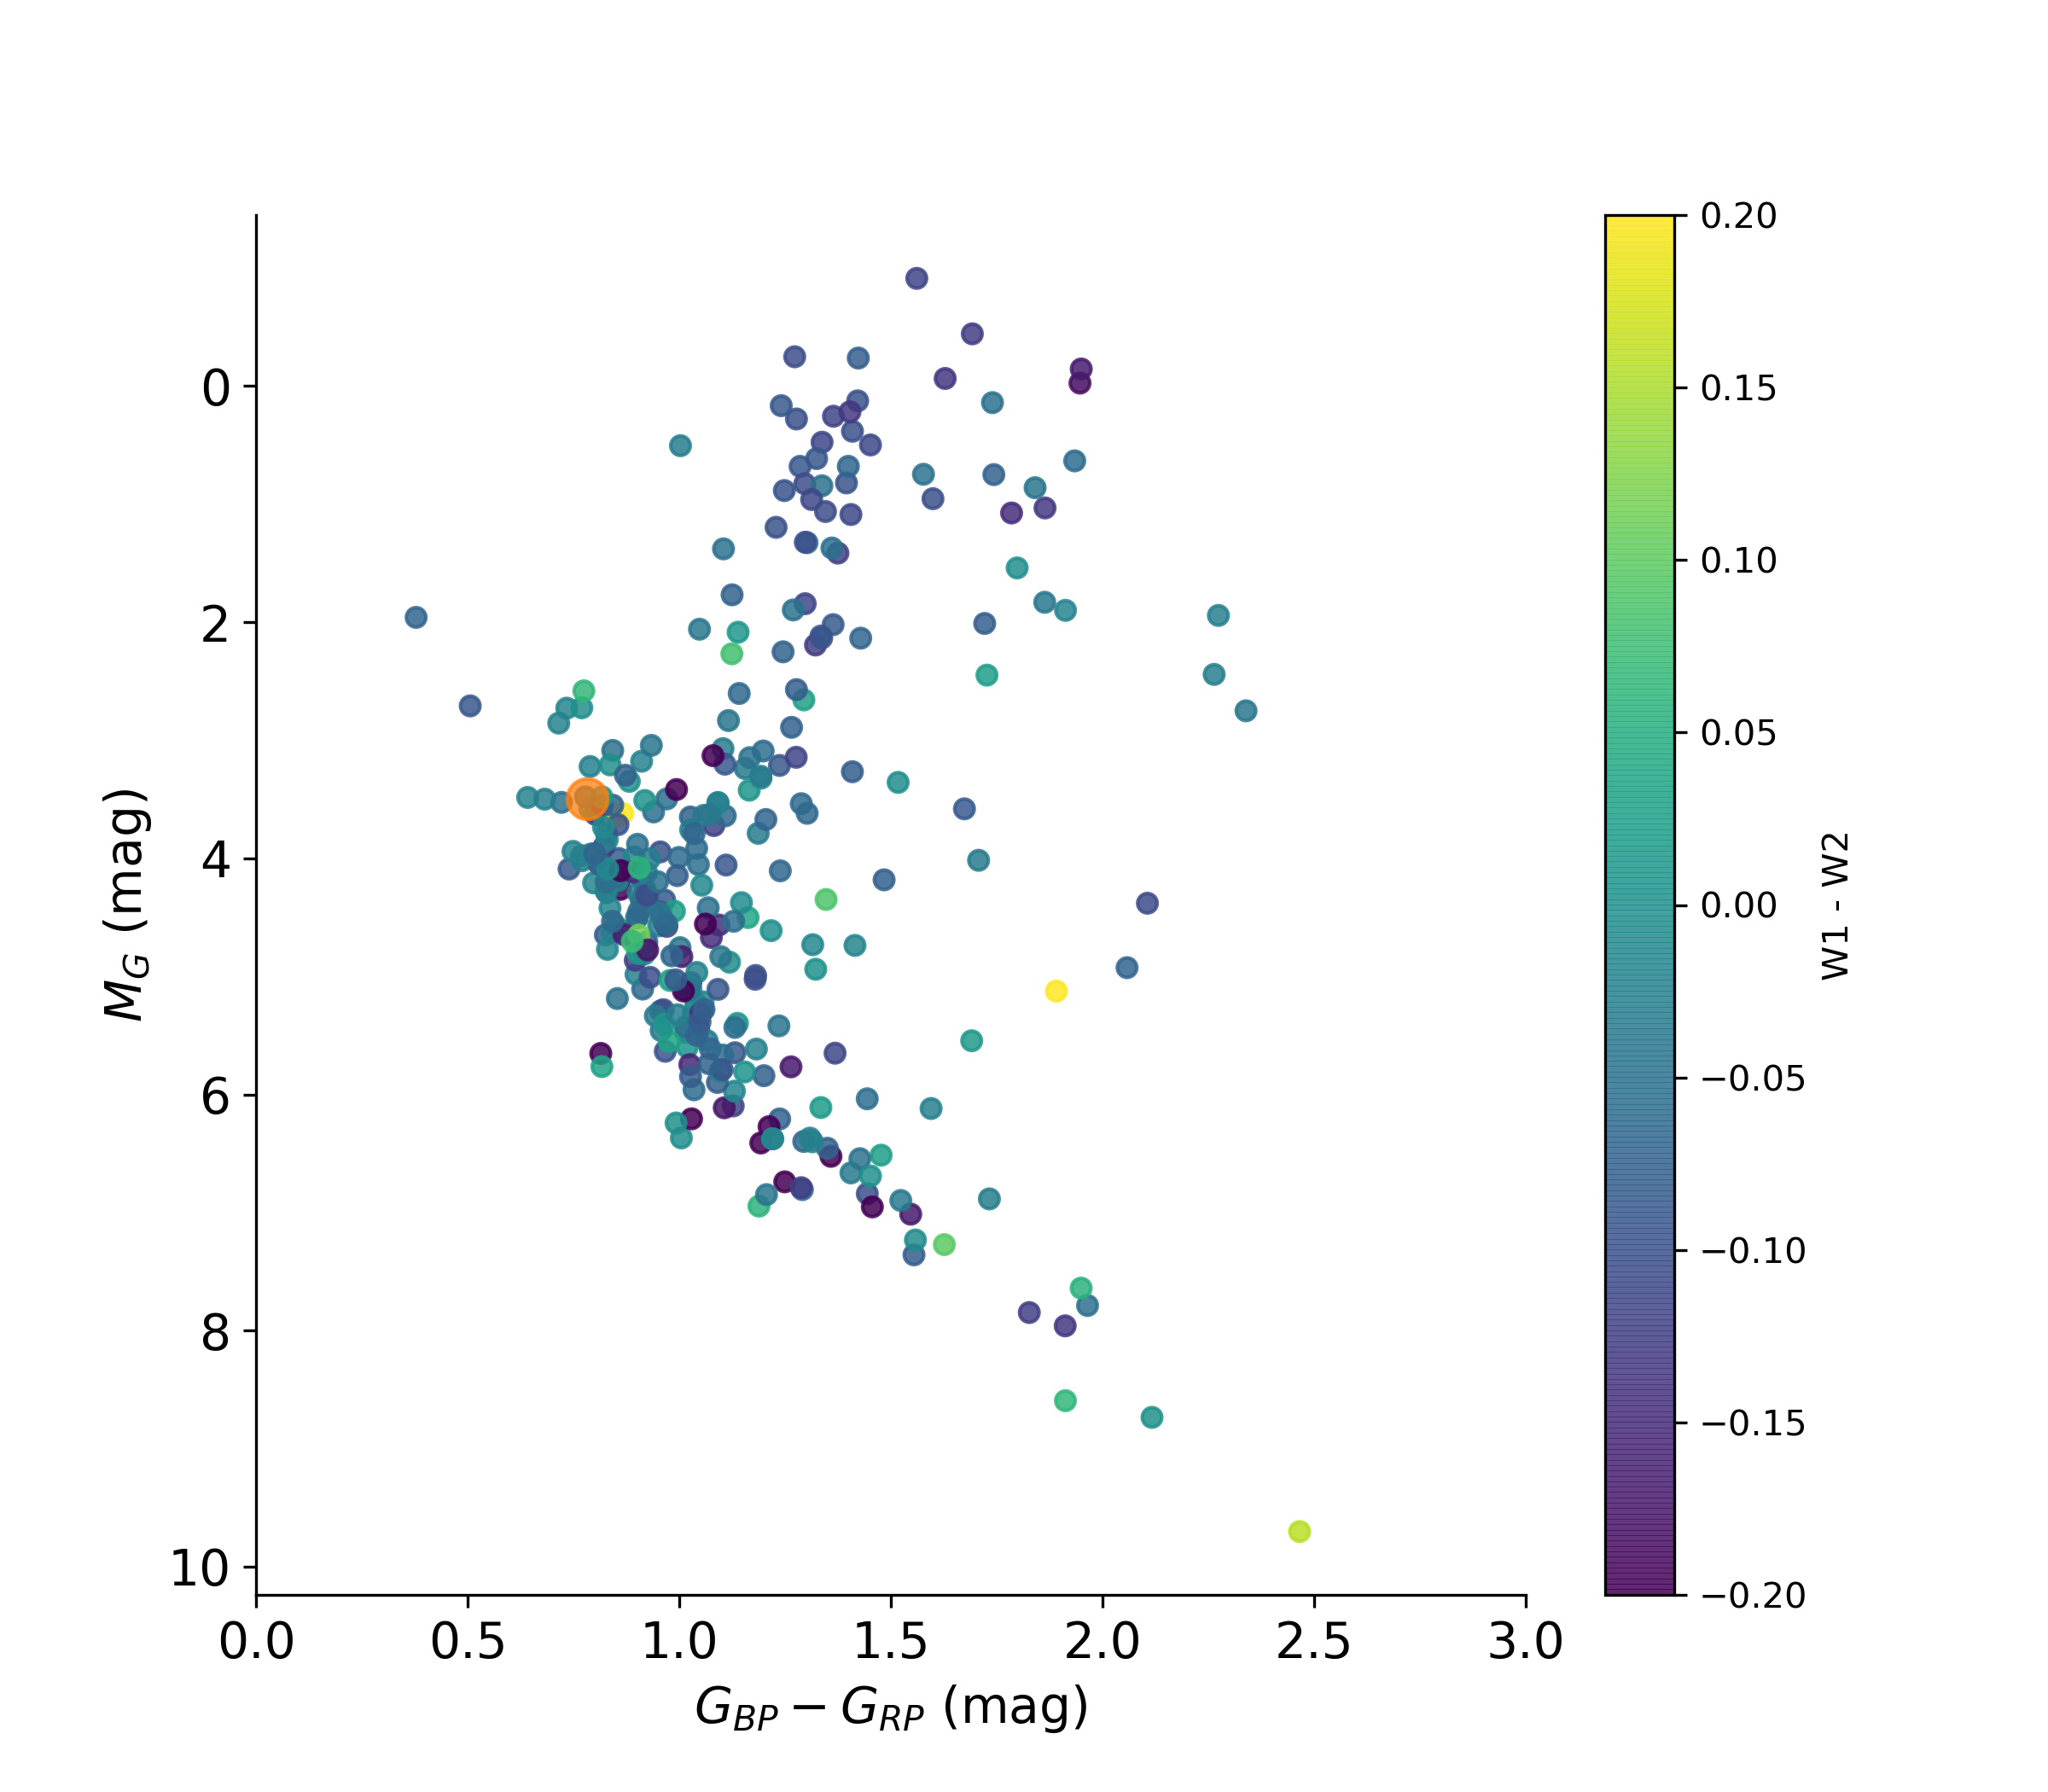

Text(0, 0.5, '$M_G$ (mag)')

In [66]:
# plt.figure()
abs_mag = gaia_wise['phot_g_mean_mag'] - 5 * np.log10(1000 / gaia_wise['parallax']) + 5

fig = plt.figure(figsize=(8,7))
ax = plt.subplot()

cut = ((gaia_wise['parallax'] / gaia_wise['parallax_error']) > 5)
plt.scatter(gaia_wise['bp_rp'][cut], abs_mag[cut], s=30, alpha=0.85, 
            c=gaia_wise['w1mpro'][cut] - gaia_wise['w2mpro'][cut])
cb = plt.colorbar()
cb.set_label("W1 - W2")
plt.clim([-0.2, 0.2])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()

bp_rp = 0.7817 # mag
phot_g_mean_mag = 11.7626 # mag
parallax = 2.2185 # mas
plt.scatter(bp_rp, phot_g_mean_mag - 5 * np.log10(1000 / parallax) + 5, s=130, c='C1', alpha=0.75)

plt.xlim(0,3)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)',fontsize=14)
plt.ylabel('$M_G$ (mag)',fontsize=14)
# plt.savefig( 'plots/cmd.png', dpi=250, bbox_inches='tight', pad_inches=0.25)


<IPython.core.display.Javascript object>


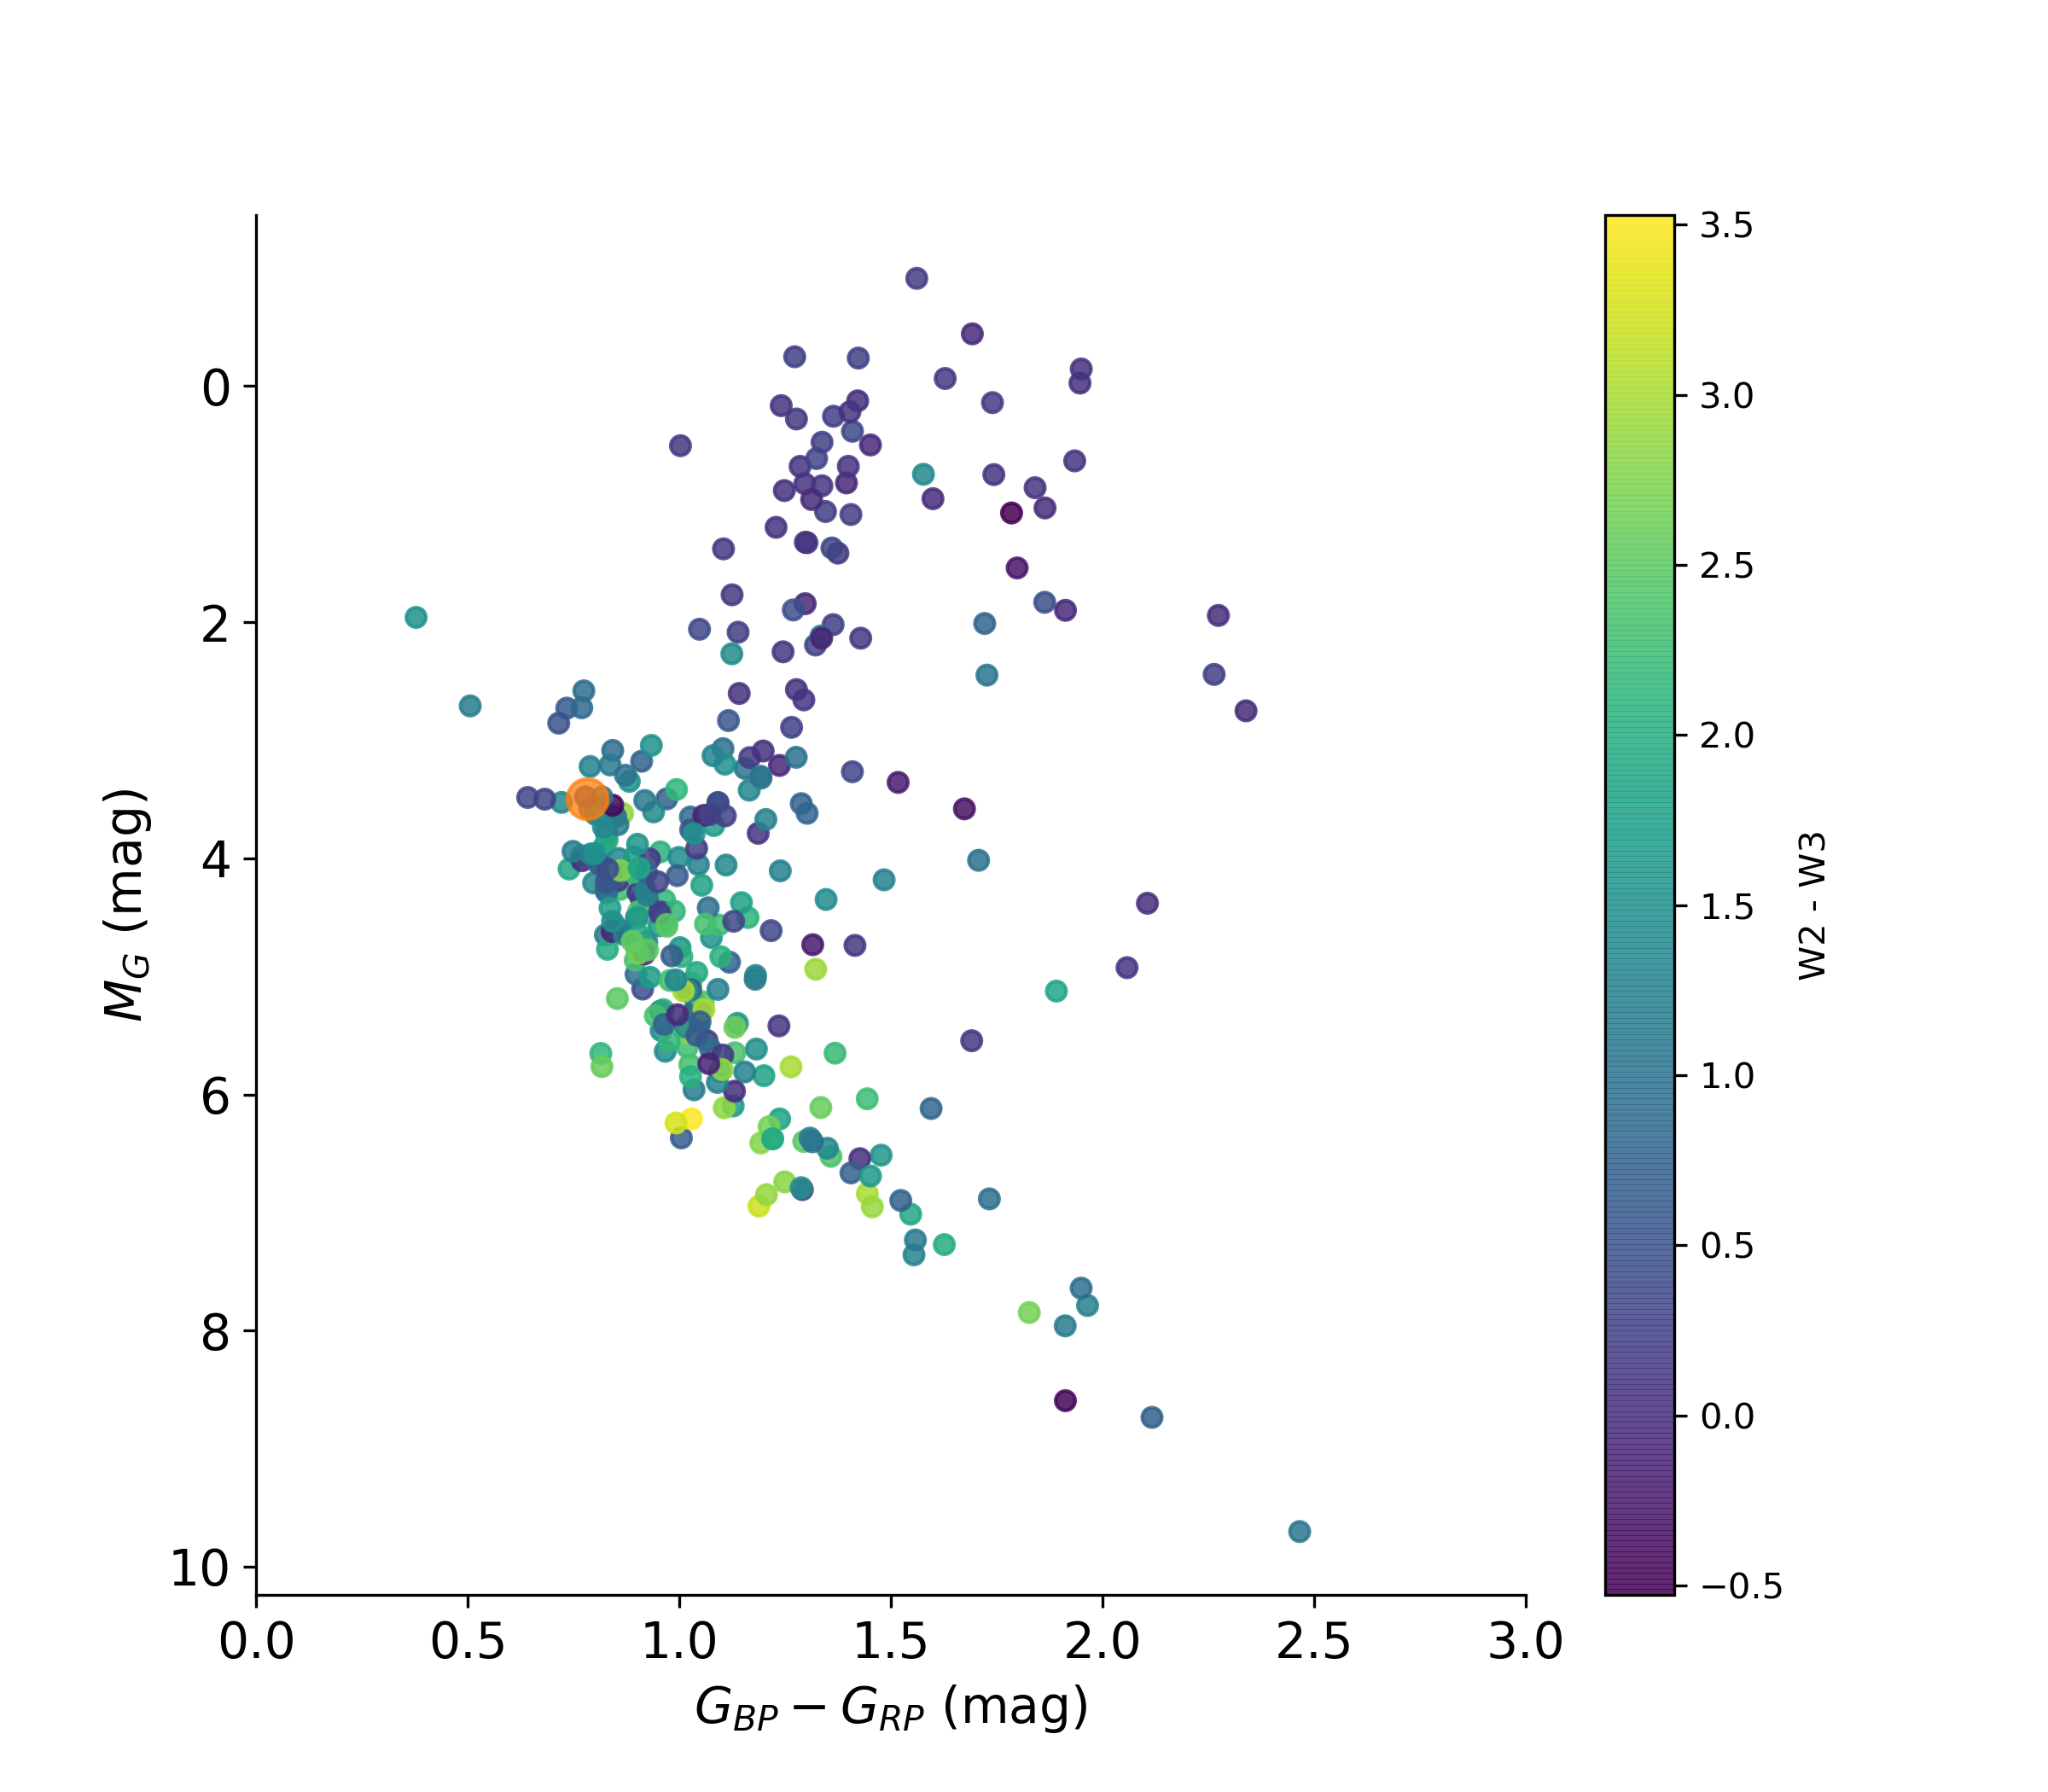

Text(0, 0.5, '$M_G$ (mag)')

In [69]:
# plt.figure()
abs_mag = gaia_wise['phot_g_mean_mag'] - 5 * np.log10(1000 / gaia_wise['parallax']) + 5

fig = plt.figure(figsize=(8,7))
ax = plt.subplot()

cut = ((gaia_wise['parallax'] / gaia_wise['parallax_error']) > 5)
plt.scatter(gaia_wise['bp_rp'][cut], abs_mag[cut], s=30, alpha=0.85, 
            c=gaia_wise['w2mpro'][cut] - gaia_wise['w3mpro'][cut])
cb = plt.colorbar()
cb.set_label("W2 - W3")
# plt.clim([-0.2, 0.2])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()

bp_rp = 0.7817 # mag
phot_g_mean_mag = 11.7626 # mag
parallax = 2.2185 # mas
plt.scatter(bp_rp, phot_g_mean_mag - 5 * np.log10(1000 / parallax) + 5, s=130, c='C1', alpha=0.75)

plt.xlim(0,3)
plt.xlabel('$G_{BP} - G_{RP}$ (mag)',fontsize=14)
plt.ylabel('$M_G$ (mag)',fontsize=14)
# plt.savefig( 'plots/cmd.png', dpi=250, bbox_inches='tight', pad_inches=0.25)


<IPython.core.display.Javascript object>


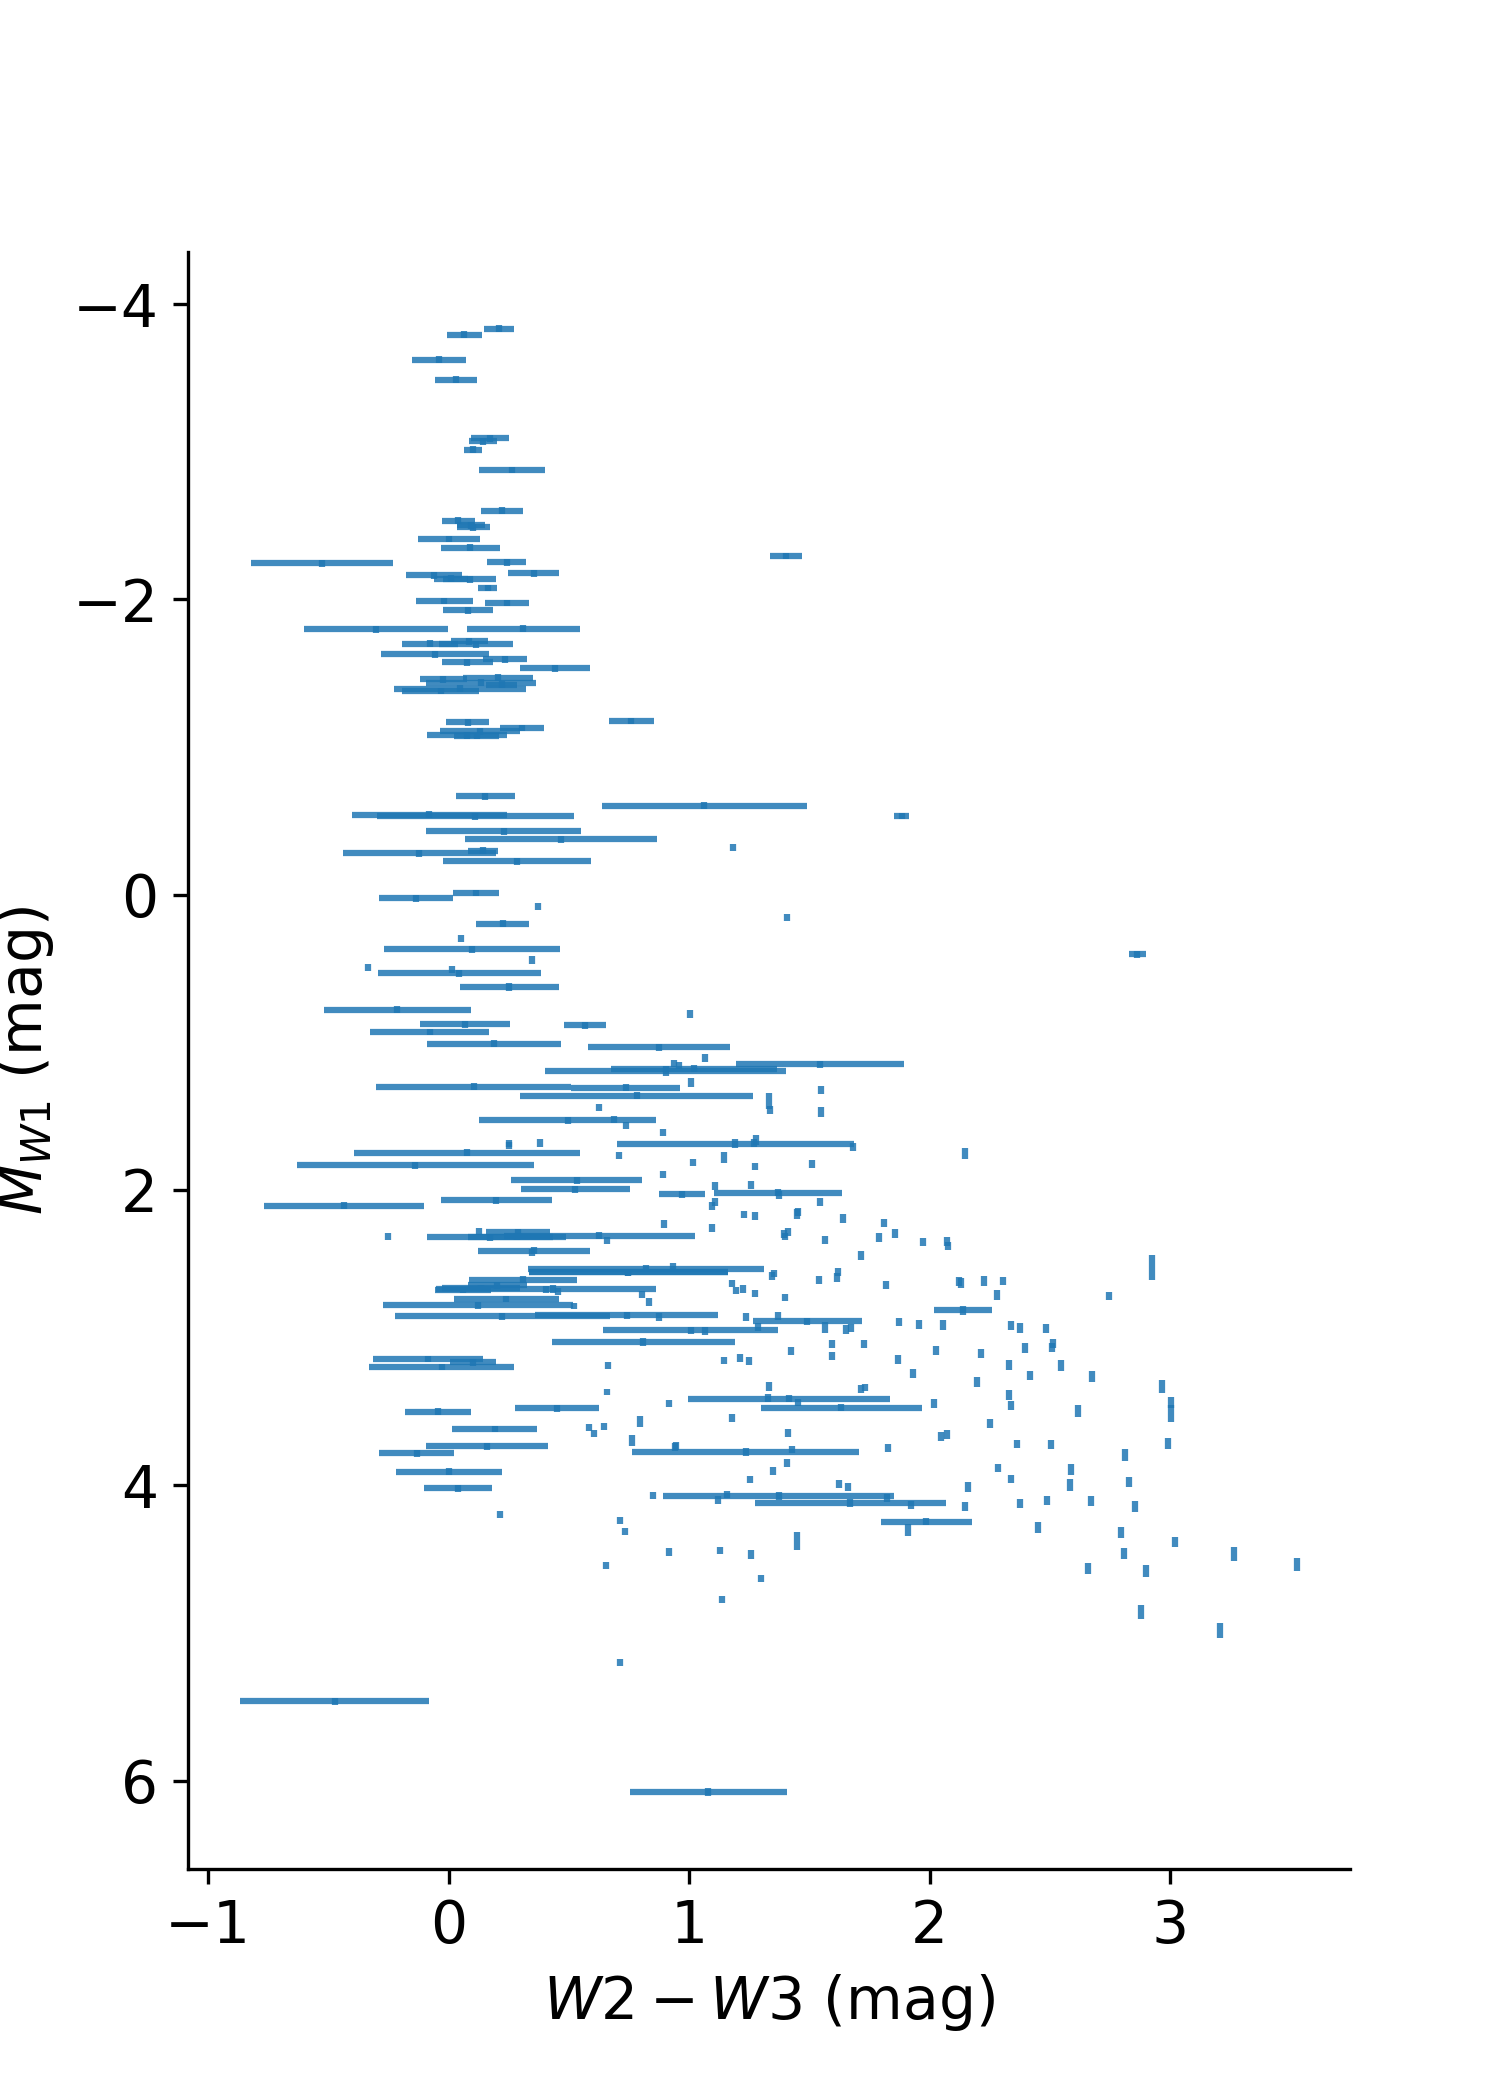

Text(0, 0.5, '$M_{W1}$ (mag)')

In [86]:
abs_mag = gaia_wise['w1mpro'] - 5 * np.log10(1000 / gaia_wise['parallax']) + 5

fig = plt.figure(figsize=(5,7))
ax = plt.subplot()

cut = ((gaia_wise['parallax'] / gaia_wise['parallax_error']) > 5)
xerr = np.sqrt(gaia_wise['w2sigmpro'][cut]**2 + gaia_wise['w3sigmpro'][cut]**2)

plt.errorbar(gaia_wise['w2mpro'][cut] - gaia_wise['w3mpro'][cut] , 
            abs_mag[cut], alpha=0.85, xerr = xerr, yerr = gaia_wise['w1sigmpro'][cut], linestyle='none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()

bp_rp = 0.7817 # mag
phot_g_mean_mag = 11.7626 # mag
parallax = 2.2185 # mas
# plt.scatter(bp_rp, phot_g_mean_mag - 5 * np.log10(1000 / parallax) + 5, s=130, c='C1', alpha=0.75)

plt.xlabel('$W2 - W3$ (mag)',fontsize=14)
plt.ylabel('$M_{W1}$ (mag)',fontsize=14)
# plt.savefig( 'plots/cmd.png', dpi=250, bbox_inches='tight', pad_inches=0.25)


<IPython.core.display.Javascript object>


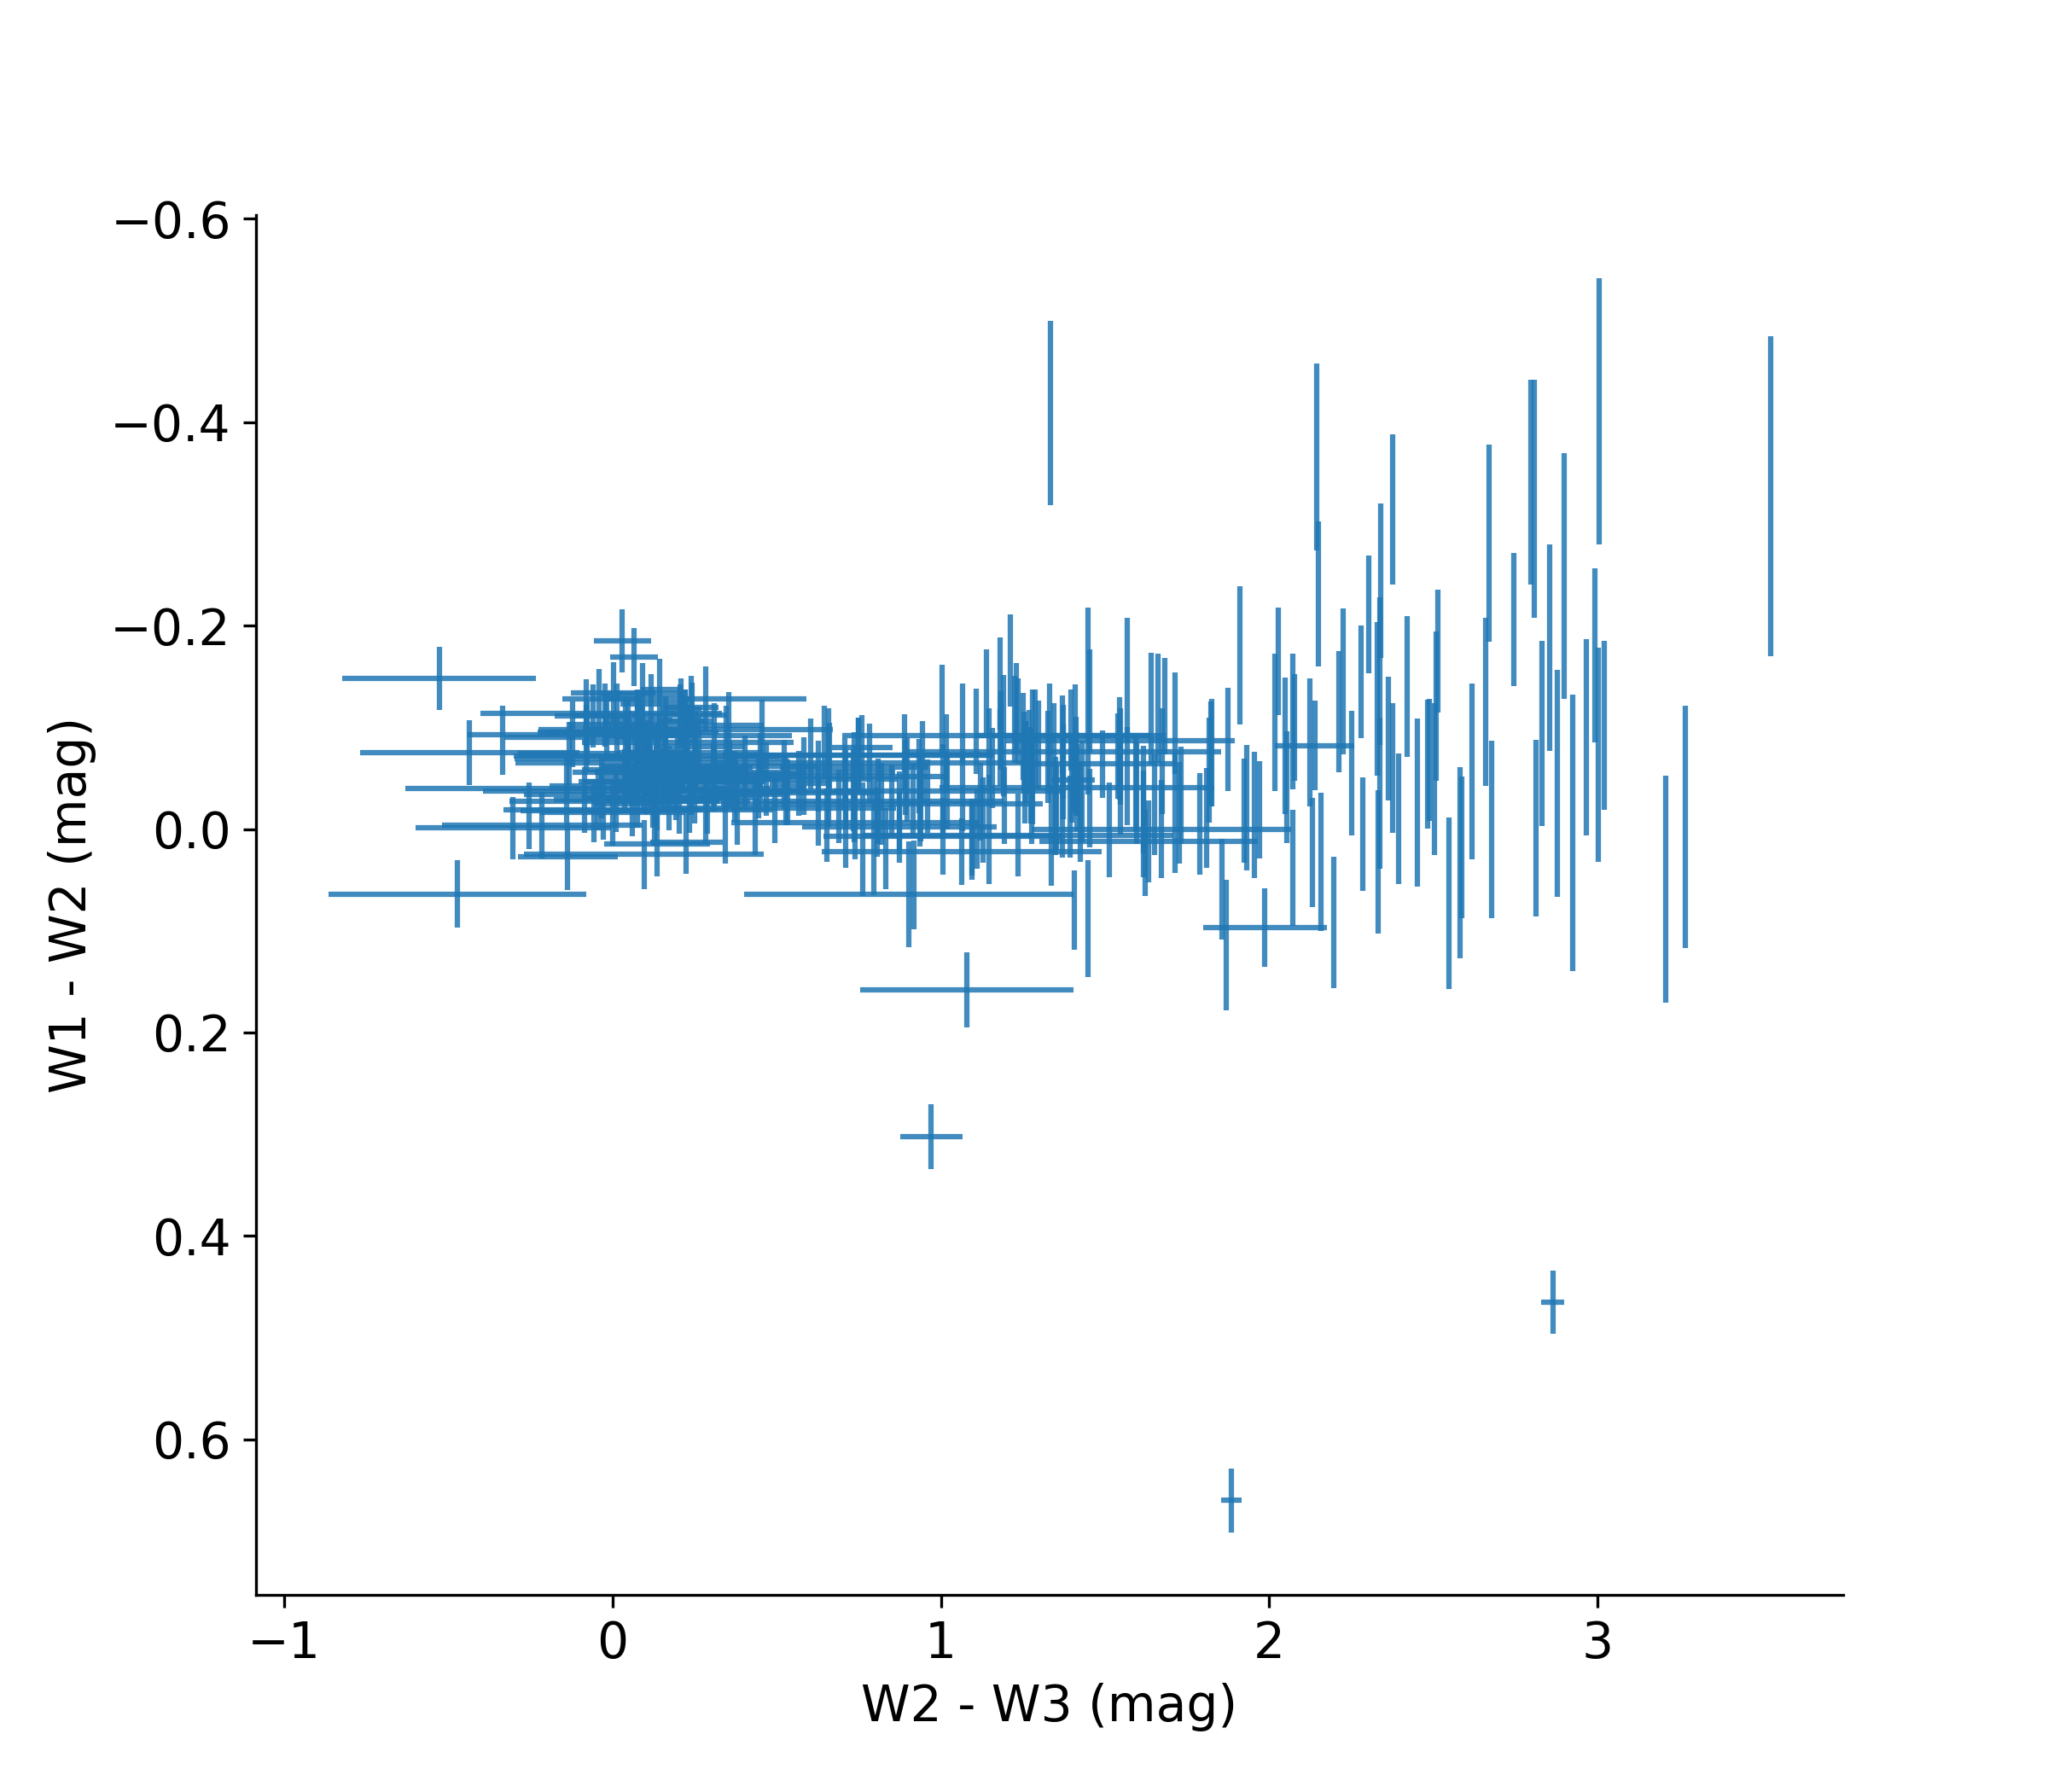

Text(0.5, 0, 'W2 - W3 (mag)')

In [88]:

fig = plt.figure(figsize=(8,7))
ax = plt.subplot()

cut = ((gaia_wise['parallax'] / gaia_wise['parallax_error']) > 5)
xerr = np.sqrt(gaia_wise['w2sigmpro'][cut]**2 + gaia_wise['w3sigmpro'][cut]**2)
yerr = np.sqrt(gaia_wise['w1sigmpro'][cut]**2 + gaia_wise['w2sigmpro'][cut]**2)

plt.errorbar(gaia_wise['w2mpro'][cut] - gaia_wise['w3mpro'][cut] , 
            gaia_wise['w1mpro'][cut] - gaia_wise['w2mpro'][cut], alpha=0.85, 
             xerr = xerr, yerr = yerr, linestyle='none')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(labelsize=14)
plt.gca().invert_yaxis()

plt.ylabel('W1 - W2 (mag)',fontsize=14)
plt.xlabel('W2 - W3 (mag)',fontsize=14)
# plt.savefig( 'plots/cmd.png', dpi=250, bbox_inches='tight', pad_inches=0.25)


<IPython.core.display.Javascript object>


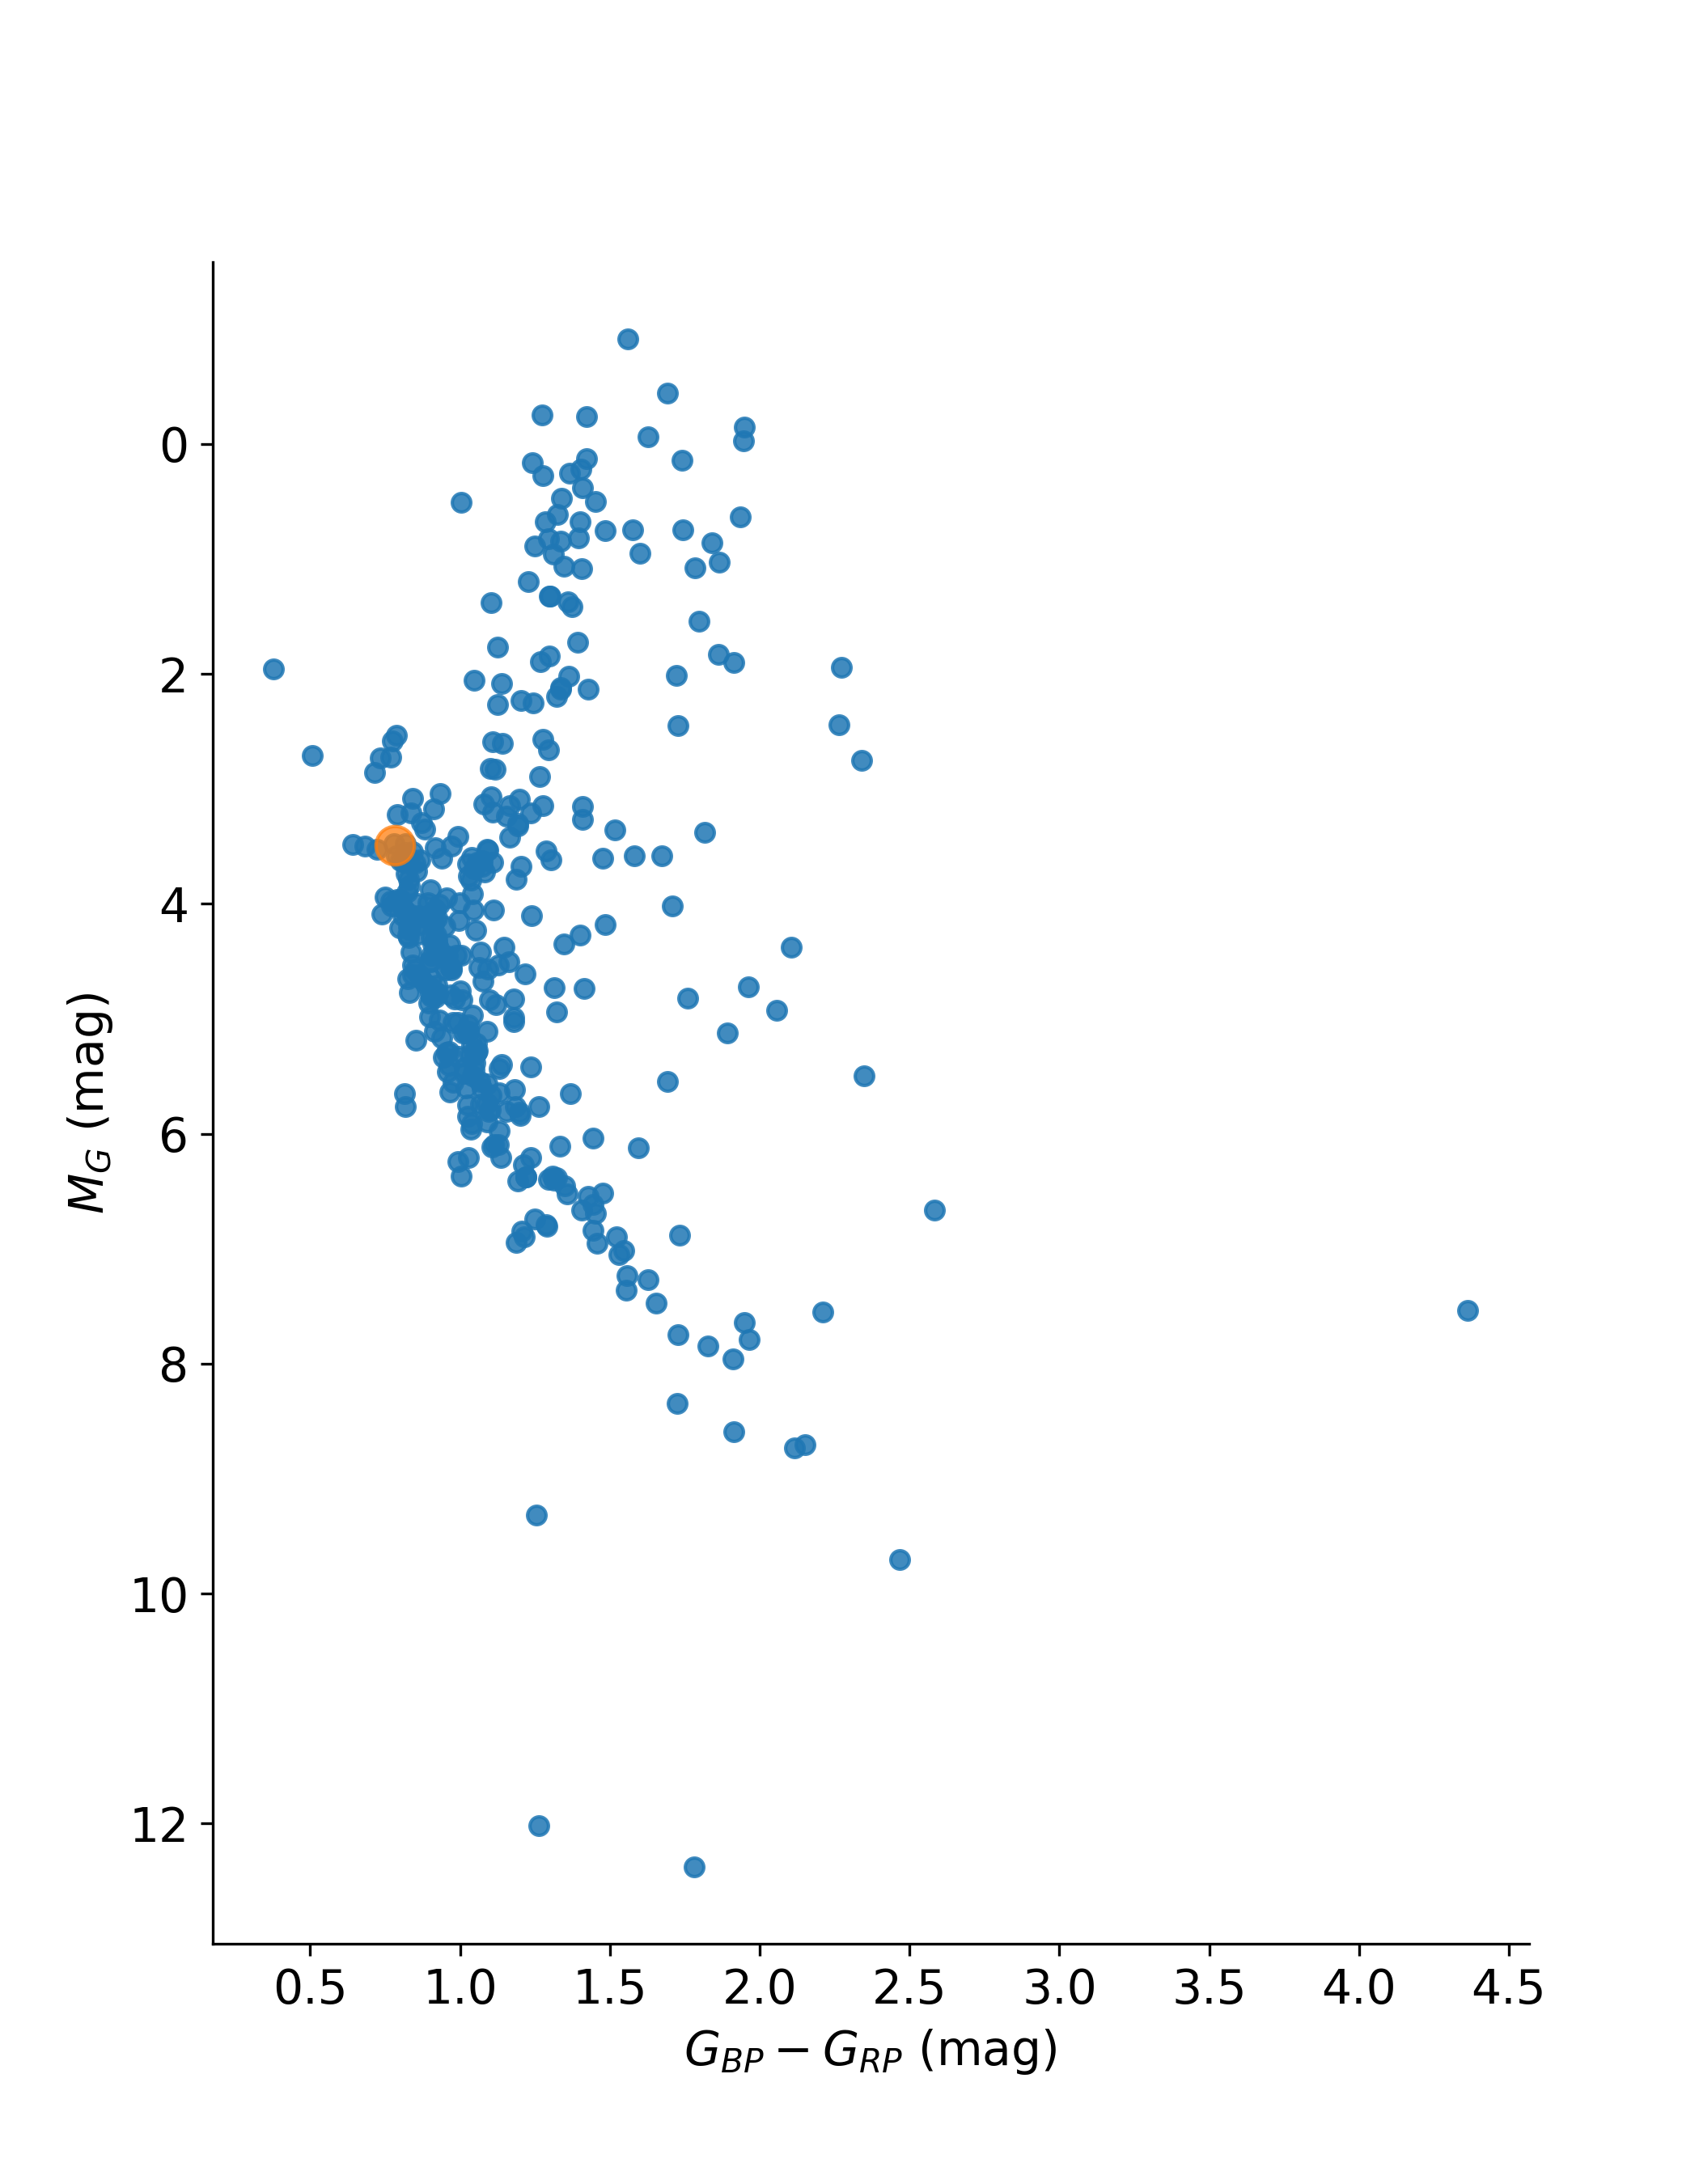

Text(0, 0.5, '$M_G$ (mag)')

In [24]:
# # plt.figure()
# abs_mag = wtf_gaia['phot_g_mean_mag'] - 5 * np.log10(1000 / wtf_gaia['parallax']) + 5

# fig = plt.figure(figsize=(7,9))
# ax = plt.subplot()

# cut = (wtf_gaia['parallax_over_error'] > 5)
# plt.scatter(wtf_gaia['bp_rp'][cut], abs_mag[cut], s=30, alpha=0.85) #, c=wtf_df20['score_g'][cut],
# # plt.colorbar()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# ax.tick_params(labelsize=14)
# plt.gca().invert_yaxis()

# bp_rp = 0.7817 # mag
# phot_g_mean_mag = 11.7626 # mag
# parallax = 2.2185 # mas
# plt.scatter(bp_rp, phot_g_mean_mag - 5 * np.log10(1000 / parallax) + 5, s=130, c='C1', alpha=0.75)

# plt.xlabel('$G_{BP} - G_{RP}$ (mag)',fontsize=14)
# plt.ylabel('$M_G$ (mag)',fontsize=14)
# # plt.savefig( 'plots/cmd.png', dpi=250, bbox_inches='tight', pad_inches=0.25)


## Next steps:
- do `.crossmatch` to WISE, and `.to_pandas()`
- do `join` with both WISE & Gaia xmatch
- make WISE-Gaia CMD for these "best" ZTF dippers!
- ...
- Profit